# Семинар 6: Пара забавностей про регрессии и экскурс в AN(С)OVA

In [1]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.set(font_scale=1.5)
warnings.simplefilter("ignore")

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

# 1. OLS & Log-reg vs. omitting variables

В данном игрушечном примере мы сравним как выбрасывание переменных влияет на оценку параметров модели в обычной линейной модели и в логистической регрессии.

Наша игрушечная модель имеет следующий вид: 

$$y = \beta_1 x_1 + \beta_2 x_2 + \epsilon, \epsilon \sim \mathcal{N}(0, 1)$$

## 1.1 Linear model

In [3]:
beta_1 = 1
beta_2 = 2.5

In [4]:
np.random.seed(1338)
N = 100000

x_1 = np.random.randn(N) * 10
x_2 = np.random.randn(N) * 10
noise = np.random.randn(N) / 5

y = x_1 * beta_1 + x_2 * beta_2 + noise

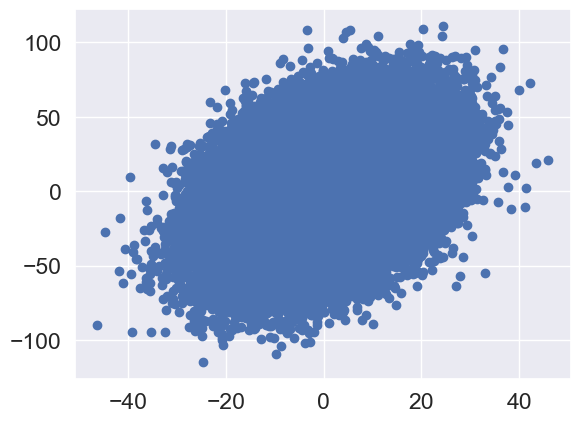

In [5]:
plt.scatter(x_1, y);

In [6]:
data = pd.DataFrame({'x_1': x_1, 'x_2': x_2, 'y': y})
fit = ols("y ~ x_1 -1", data).fit()
print(fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.139
Model:                            OLS   Adj. R-squared (uncentered):              0.139
Method:                 Least Squares   F-statistic:                          1.609e+04
Date:                Mon, 20 Feb 2023   Prob (F-statistic):                        0.00
Time:                        13:01:24   Log-Likelihood:                     -4.6365e+05
No. Observations:              100000   AIC:                                  9.273e+05
Df Residuals:                   99999   BIC:                                  9.273e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# 1.2 Log-reg model

In [7]:
from scipy.stats import norm 
def probit(x):
    return norm.cdf(x)

data['y'] = probit(y)

In [9]:
fit = smf.glm('y ~ x_1 -1', 
              data=sm.add_constant(data), 
              family=sm.families.Binomial(sm.families.links.probit())).fit()

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99999
Model Family:                Binomial   Df Model:                            0
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63919.
Date:                Mon, 20 Feb 2023   Deviance:                   1.2416e+05
Time:                        13:02:26   Pearson chi2:                 9.63e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08773
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_1            0.0401      0.000     92.804      0.0

### ``Attenuation'' bias

https://stats.stackexchange.com/questions/113766/omitted-variable-bias-in-logistic-regression-vs-omitted-variable-bias-in-ordina/113832#113832

http://esr.oxfordjournals.org/content/26/1/67.full.pdf?keytype=ref&ijkey=R3RzO51agvA7eKQ

#### tl;dr если мы не используем какую-то фичу из данных, то другие переменные смещаются к нулю


$$\hat\beta_1 \rightarrow \frac{\beta_1}{\sqrt{1 + \beta_2^2 \sigma^2_{x_2}}}$$

In [10]:
beta_1 / np.sqrt(1 + beta_2**2 * 100)

0.039968038348871575

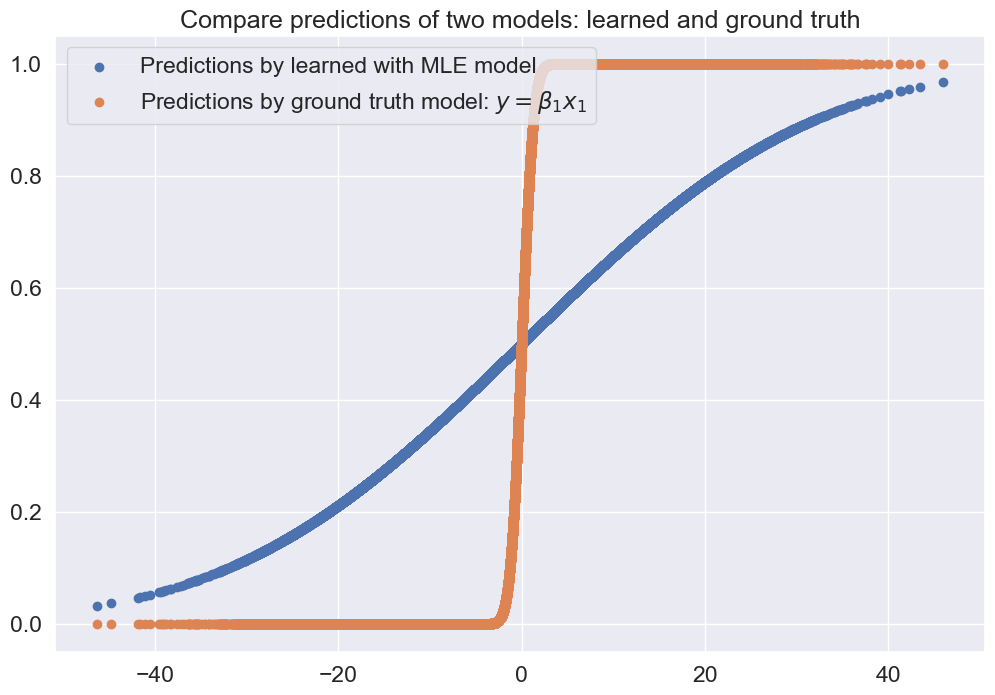

In [11]:
plt.figure(figsize=(12, 8))
plt.title("Compare predictions of two models: learned and ground truth")
plt.scatter(data['x_1'], fit.predict(data['x_1']).values, label="Predictions by learned with MLE model");
plt.scatter(data['x_1'], probit(x_1 * beta_1), label=r"Predictions by ground truth model: $y = \beta_1 x_1$");
plt.legend()
plt.show()

# 2. Measurement error

Проведём следующий мысленный эксперимент: возьмём линейную модель и добавим шум в измеряемую величину $x_1$:

$$y = \beta_1 (x_1) + \beta_2 x_2$$


При этом в реальности мы наблюдаем зашумлённую величину:

$$\hat x_1 = x_1 + \epsilon, \epsilon \sim \mathcal{N}(0, 1)$$

In [12]:
np.random.seed(1338)
N = 10000
x_1 = np.random.randn(N)
x_2 = np.random.randn(N)

y = x_1 * beta_1 + x_2 * beta_2

x_1_noise = x_1 + np.random.randn(N)

In [13]:
data = pd.DataFrame(
    {
        'x_1': x_1_noise, 
        'x_2': x_2, 
        'y': y
    }
)
fit = ols("y ~ x_1 + x_2 -1", data).fit()
print(fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                          6.609e+04
Date:                Mon, 20 Feb 2023   Prob (F-statistic):                        0.00
Time:                        13:02:30   Log-Likelihood:                         -10727.
No. Observations:               10000   AIC:                                  2.146e+04
Df Residuals:                    9998   BIC:                                  2.147e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Это называется ошибкой измерения.

http://econ.lse.ac.uk/staff/spischke/ec524/Merr_new.pdf

$$\hat\beta_1  - \beta_1 = - \frac{\sigma_{x_1}^2}{\sigma_{x_1}^2 + \sigma_{\epsilon}^2} \beta_1$$

## Что делать?

1. Если вы знаете $\sigma_{x_1}$ и $\sigma_{\epsilon}$, то всё супер.

2. Предположим что не знаете, но вы можете измерить какую-то величину $z$, которая скоррелирована с $x_1$, но не зависит от $\epsilon$, то несмещённую оценку можно посчитать следующим образом:

$$\beta_{1} = \frac{\mathrm{Cov}(z, y)}{\mathrm{Cov}(z, x)}$$

In [14]:
z = 5 * np.sin(x_1) + np.random.randn(N) 

In [15]:
np.cov(z, y)[1, 0] / np.cov(z, x_1_noise)[1, 0]

0.9557678473483447

# 2. ANOVA

## Данные для экспериментов

![](cylinders.jpeg)

Мы будем смотреть на данные по MPG (=Miles Per Gallon) и строить различные о зависимостях в данных

Переменные c которыми мы будем работать (https://archive.ics.uci.edu/ml/datasets/auto+mpg):

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

In [16]:
auto_mpg = pd.read_csv('./auto_mpg.data',sep='\s+',names = ['MPG','Cylinders','Displacement',
                                                        'Horse_power','Weight','Acceleration',
                                                        'Model_Year','Origin','Car_Name'])
auto_mpg = auto_mpg[auto_mpg.Horse_power.apply(lambda x: not '?' in x)]
auto_mpg.Horse_power = auto_mpg.Horse_power.apply(lambda x: float(x))
auto_mpg.reset_index(drop=True, inplace=True)

In [17]:
auto_mpg.MPG = np.log(1 / auto_mpg.MPG)

In [18]:
auto_mpg.head()

,MPG,Cylinders,Displacement,Horse_power,Weight,Acceleration,Model_Year,Origin,Car_Name
0,-2.890372,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,-2.708050,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,-2.890372,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,-2.772589,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,-2.833213,8,302.0,140.0,3449.0,10.5,70,1,ford torino


##### Посмотрим на распределение MPG от лошадиных сил

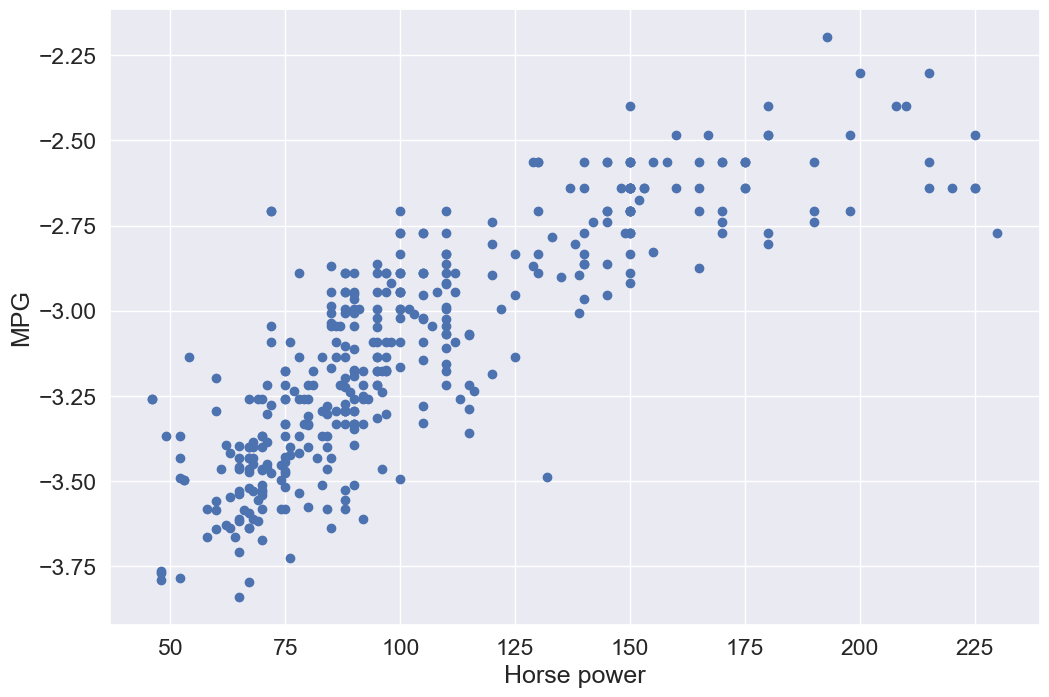

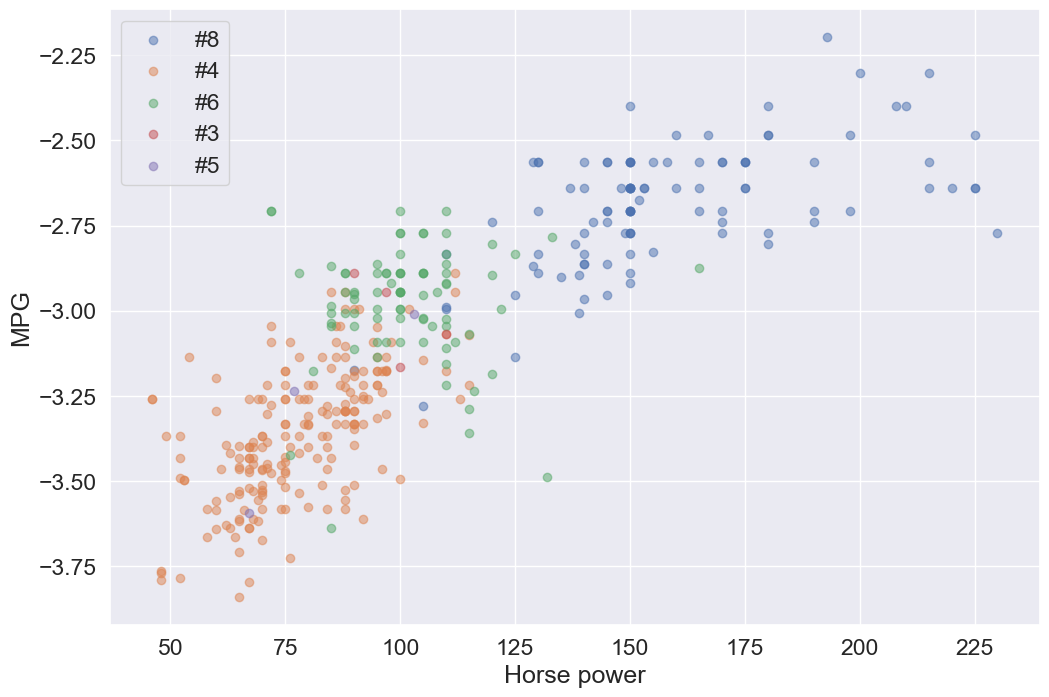

In [19]:
plt.figure(figsize=(12, 8))
plt.scatter(auto_mpg['Horse_power'], auto_mpg['MPG'])
plt.xlabel('Horse power')
plt.ylabel('MPG')
plt.show()

plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter(auto_mpg['Horse_power'][auto_mpg.Cylinders==cylinder], 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], alpha=0.5, 
                label='#{}'.format(cylinder))
plt.xlabel('Horse power')
plt.ylabel('MPG')
plt.legend()
plt.show()

### Посмотрим на распределение MPG от веса двигателя

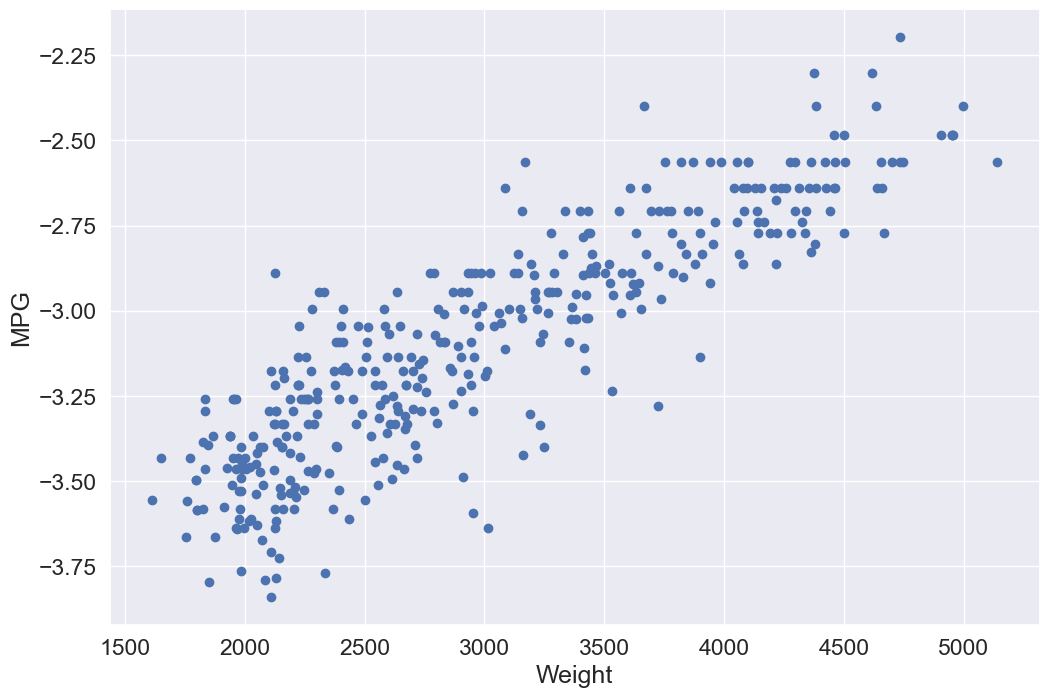

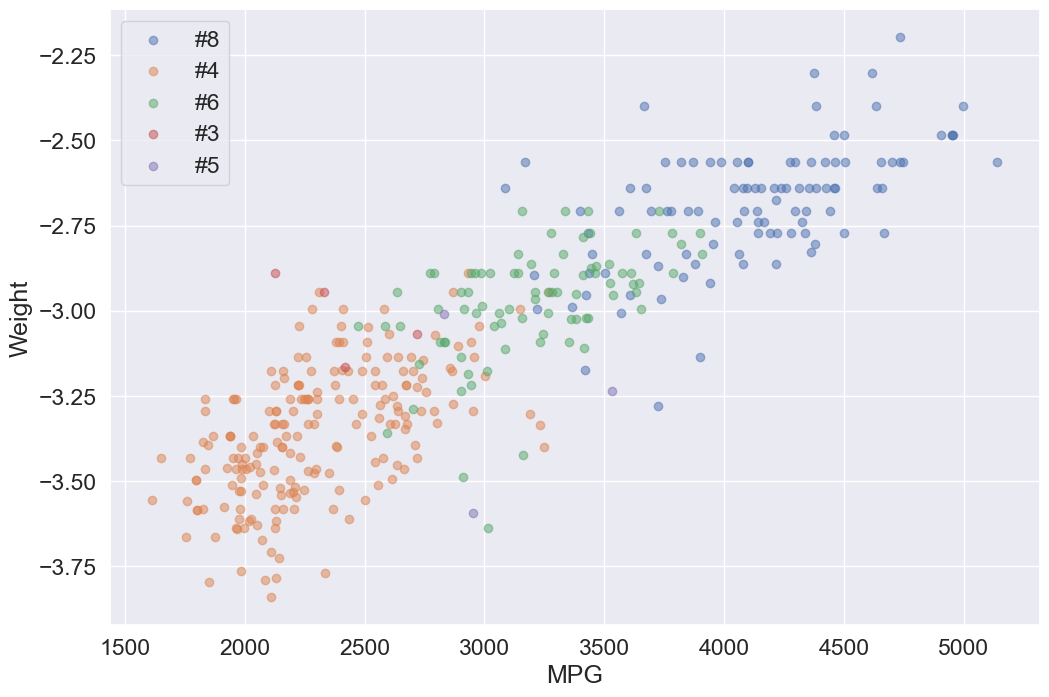

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(auto_mpg['Weight'], auto_mpg['MPG'])
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.show()

plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter(auto_mpg['Weight'][auto_mpg.Cylinders==cylinder], 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], 
                alpha=0.5, label='#{}'.format(cylinder))
plt.xlabel('MPG')
plt.ylabel('Weight')
plt.legend()
plt.show()

### Посмотрим на распределение MPG от числа цилиндров

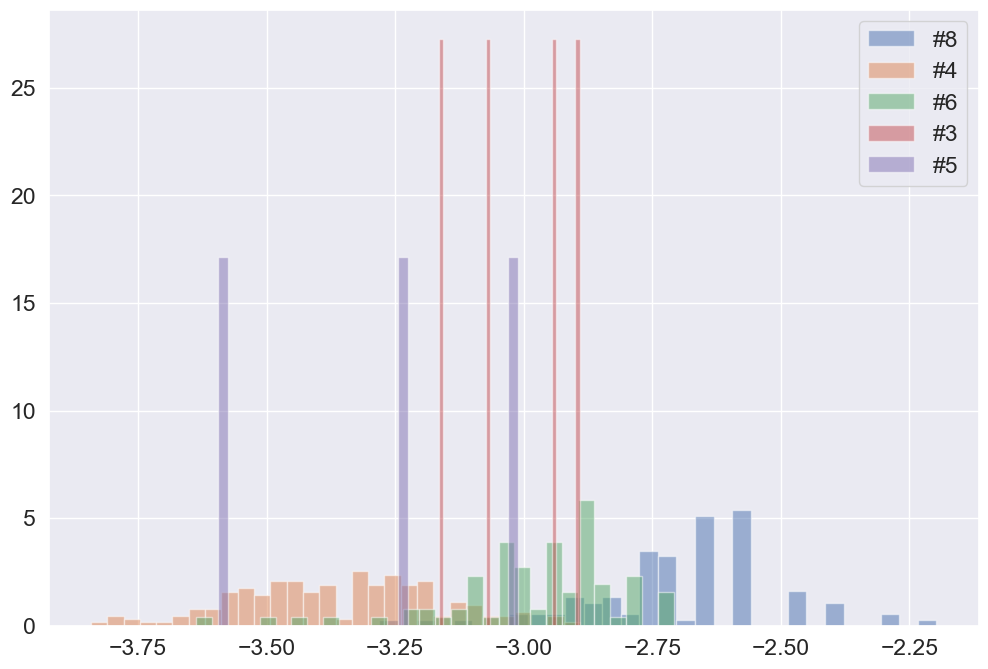

<Figure size 640x480 with 0 Axes>

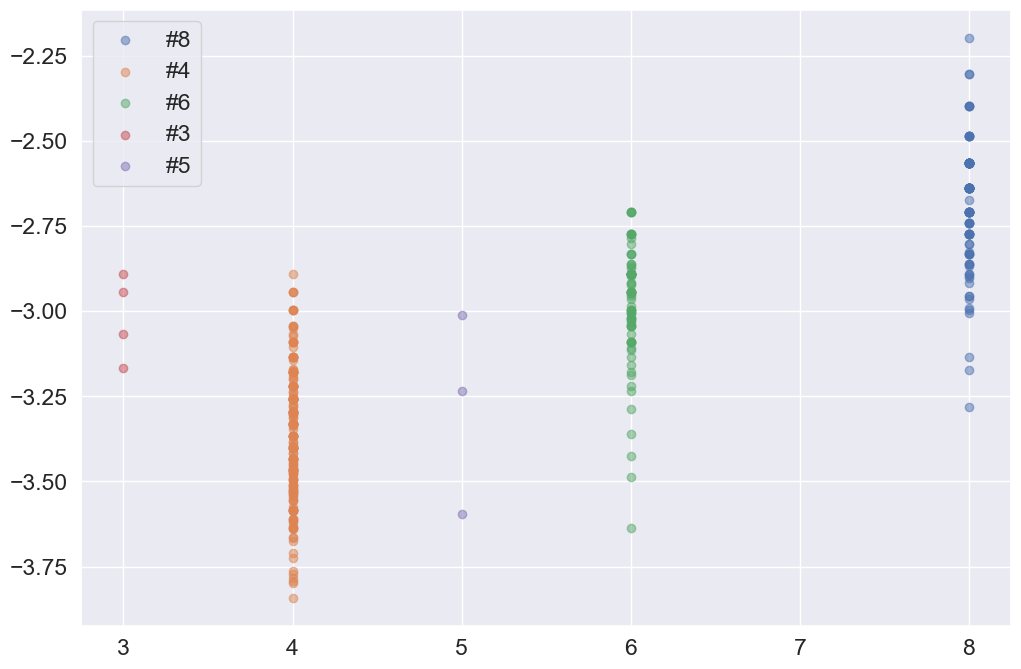

In [21]:
plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.hist(auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], 
             bins=30, alpha=0.5, label='#{}'.format(cylinder), density=True)
plt.legend()
plt.show()

fig = plt.figure()
plt.figure(figsize=(12, 8))
for cylinder in auto_mpg.Cylinders.unique():
    plt.scatter([cylinder] * len(auto_mpg['MPG'][auto_mpg.Cylinders==cylinder]), 
                auto_mpg['MPG'][auto_mpg.Cylinders==cylinder], alpha=0.5, 
            label='#{}'.format(cylinder))
plt.legend()
plt.show()

In [22]:
auto_mpg[auto_mpg["Cylinders"] == 3]

,MPG,Cylinders,Displacement,Horse_power,Weight,Acceleration,Model_Year,Origin,Car_Name
70,-2.944439,3,70.0,97.0,2330.0,13.5,72,3,mazda rx2 coupe
110,-2.890372,3,70.0,90.0,2124.0,13.5,73,3,maxda rx3
241,-3.068053,3,80.0,110.0,2720.0,13.5,77,3,mazda rx-4
331,-3.165475,3,70.0,100.0,2420.0,12.5,80,3,mazda rx-7 gs


##### Посмотрим на распределение MPG от страны производителя

In [23]:
auto_mpg.Origin.unique()

array([1, 3, 2])

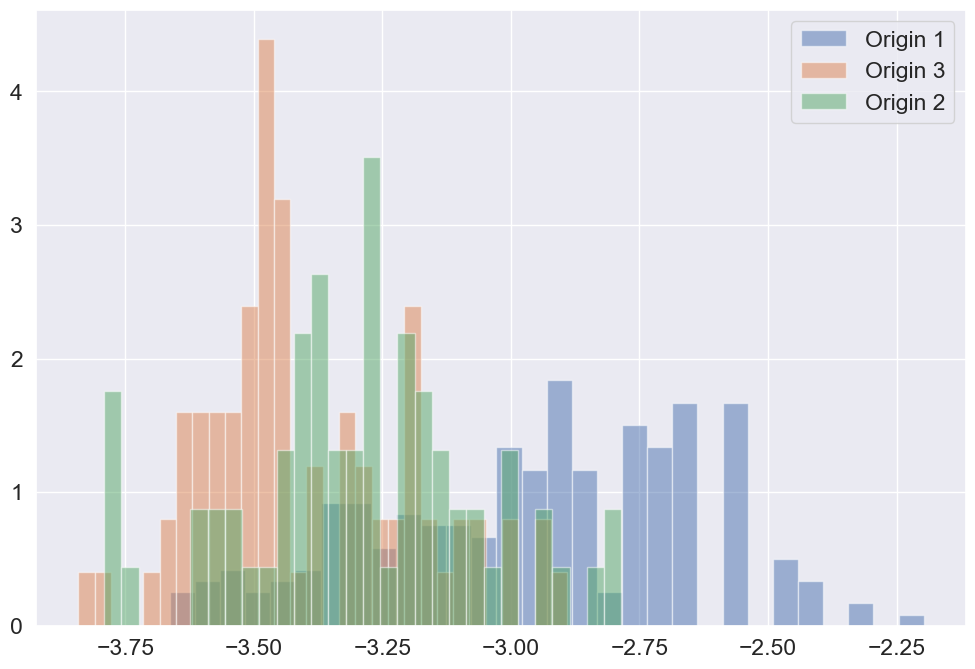

<Figure size 640x480 with 0 Axes>

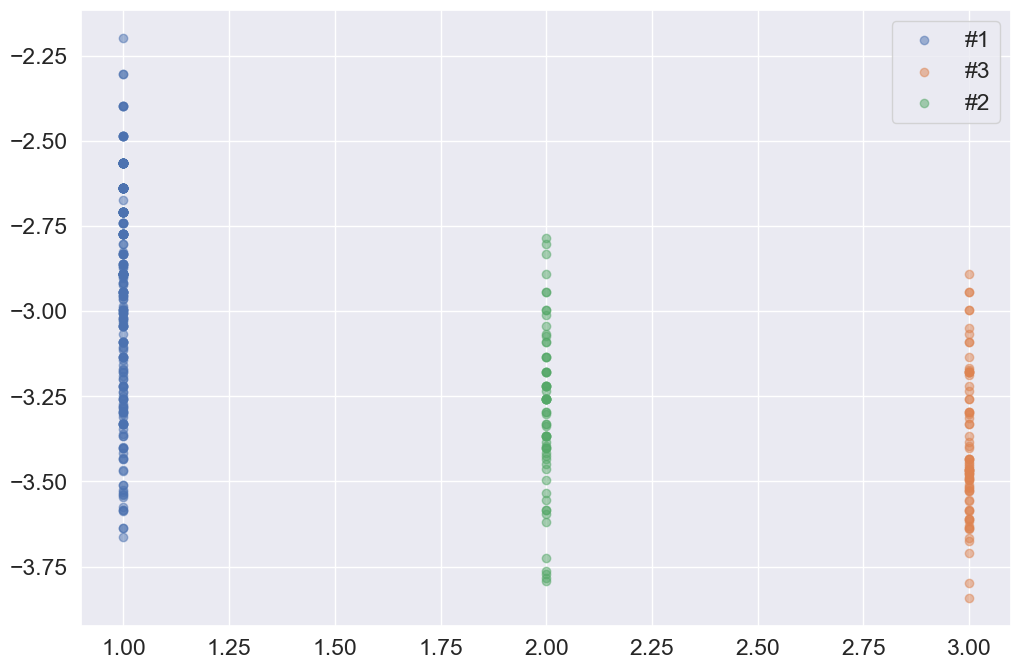

In [24]:
plt.figure(figsize=(12, 8))
for origin in auto_mpg.Origin.unique():
    plt.hist(auto_mpg['MPG'][auto_mpg.Origin==origin], 
             bins=30, alpha=0.5, label='Origin {}'.format(origin), density=True)
plt.legend()
plt.show()

fig = plt.figure()
plt.figure(figsize=(12, 8))
for origin in auto_mpg.Origin.unique():
    plt.scatter([origin] * len(auto_mpg['MPG'][auto_mpg.Origin==origin]), 
                auto_mpg['MPG'][auto_mpg.Origin==origin], alpha=0.5, 
                label='#{}'.format(origin))
plt.legend()
plt.show()

## F-test & ANOVA

F-распределение (распределение Фишера):

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a55e68498f7fd2c02998e8692ce340c3e9a5cedf)


Параметризуется двумя величинами: $d_1$ и $d_2$, которые называют степенями свободы.


Почему степенями свободы? Потому что распределение Фишера можно записать как отношение двух хи-квадратов:

$$F=\frac{\chi^2(d_1) / d_1}{\chi^2(d_2) / d_2}$$

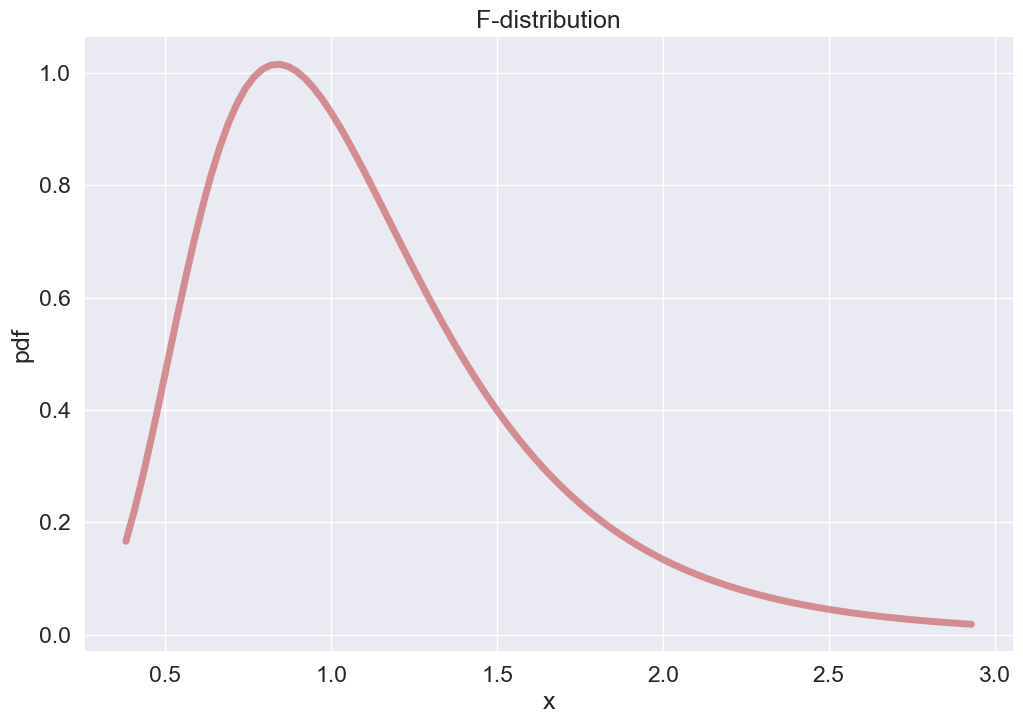

In [25]:
from scipy.stats import f
dfn, dfd = 29, 18

x = np.linspace(f.ppf(0.01, dfn, dfd),
                f.ppf(0.99, dfn, dfd), 100)

plt.figure(figsize=(12, 8))

plt.plot(x, f.pdf(x, dfn, dfd), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.title('F-distribution')

plt.xlabel('x')
plt.ylabel('pdf')

plt.show()

## Самая главная табличка ANOVA


#### Какую гипотезу мы проверяем?

$$\mathbb{H}_0:~~\textrm{все средние равны}$$  $$~~\mathrm{vs}~~$$  $$\mathbb{H}_1: ~~ \textrm{не все средние равны}$$

#### Для этого мы первым делом строим табличку дисперсий

| Тип дисперсии  |  SS | df  | MS  | F  |
|---|---|---|---|---|
| Между групп  | SSG | k - 1 | MSG = SSG / (k - 1)  |  MSG / MSE |
| Внутри групп  | SSE  | n - k  | MSE = SSE / (n - k)  |   |
| Полная  |  SST | n - 1  |   |   |


Какой смысл у каждого типа вариации (дисперсии)?

  * Между группами (MSG): дисперсия между средними подсчитанными для каждой из группы и глобальным средним;
  * Внутри групп (MSE): дисперсия между измерениями и групповыми средними;
  * Полная: вариация между измерениями и глобальным средним.

#### После чего мы считаем F-стастистику:


$$F = \frac{MSG}{MSE}$$


Раньше мы записывали что:

$$s^2 = \frac{1}{n - 1} \sum (x_i - \bar{x})^2$$

$$(n - 1) \frac{s^2}{\sigma^2} \sim \chi^2_{n-1}$$

Используя эту формулу явным образом выводится, что $MSG / MSE$ имеет $F$-распределение.

#### И после этого мы  можем тестировать гипотезу:

Если нулевая гипотеза гипотеза верна, то $F$-статистика должна иметь F-распределение со степенями свободы $k-1$ и $n - k$.

Если $P(F_{k-1, n - k} > F) < \alpha$, то $H_0$ отклоняется.

## ANOVA в `statsmodels`

In [26]:
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

Зафитируем линейную модель по зависимости MPG от количества цилиндров:

In [27]:
formula = 'MPG ~ C(Cylinders) + np.log(Weight)'
lm = ols(formula, auto_mpg).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     294.3
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          2.93e-129
Time:                        13:02:35   Log-Likelihood:                 175.07
No. Observations:                 392   AIC:                            -338.1
Df Residuals:                     386   BIC:                            -314.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -8.9705      0.48

##### То как видит данные линейная модель

In [28]:
lm.model.data.orig_exog[:5]

,Intercept,C(Cylinders)[T.4],C(Cylinders)[T.5],C(Cylinders)[T.6],C(Cylinders)[T.8],np.log(Weight)
0,1.0,0.0,0.0,0.0,1.0,8.161660
1,1.0,0.0,0.0,0.0,1.0,8.214194
2,1.0,0.0,0.0,0.0,1.0,8.142063
3,1.0,0.0,0.0,0.0,1.0,8.141190
4,1.0,0.0,0.0,0.0,1.0,8.145840


In [29]:
infl = lm.get_influence()
summary_table = infl.summary_table()

Теперь построим ошибки (residuals).

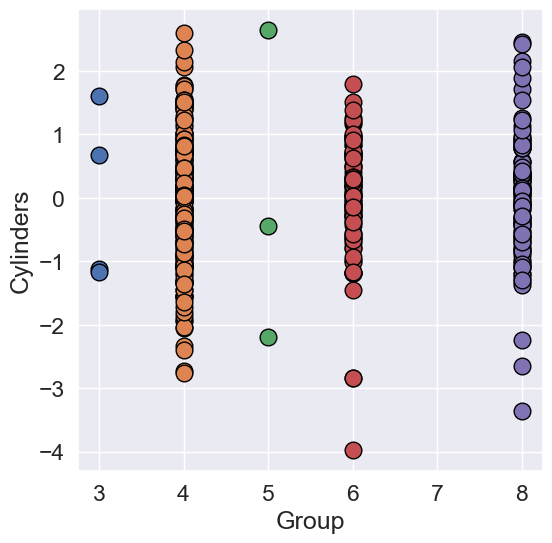

In [30]:
resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Cylinders']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Cylinders');

In [31]:
len(auto_mpg) - 5

387

In [32]:
anova_table = anova_lm(lm)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cylinders),4.0,32.049300,8.012325,329.192112,5.958424e-123
np.log(Weight),1.0,3.765669,3.765669,154.715208,4.224221e-30
Residual,386.0,9.394992,0.024339,NaN,NaN


##### Построим ошибки как функцию от веса двигателя

Кажется, что есть лёгкий тренд?..

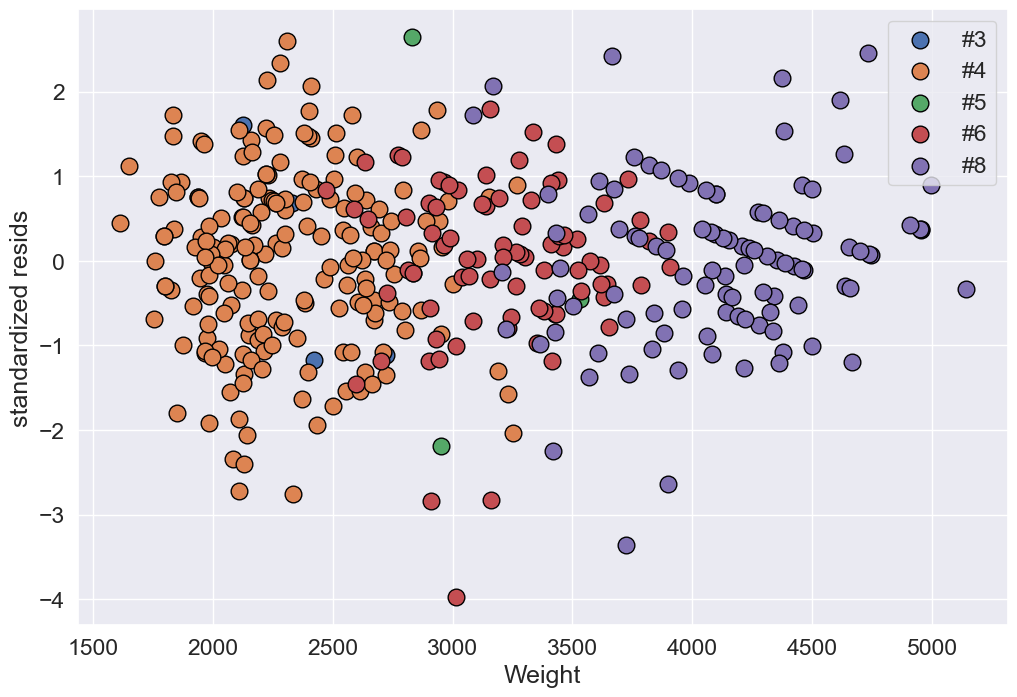

In [33]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Cylinders']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='#{}'.format(cylinder))
plt.xlabel('Weight');
plt.ylabel('standardized resids');
plt.legend();

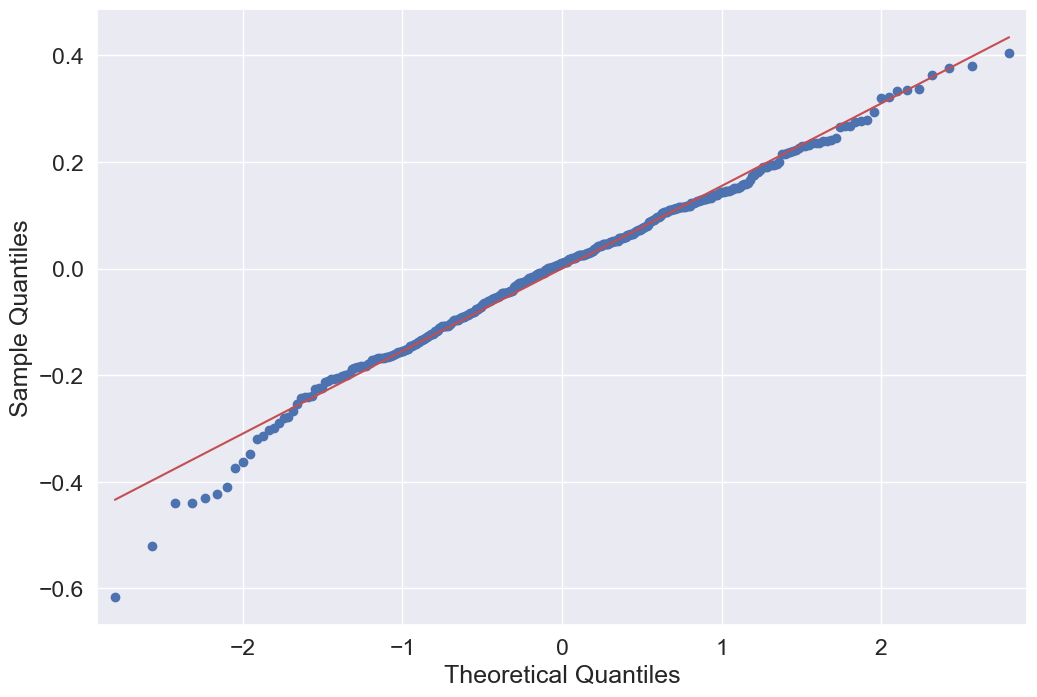

In [34]:
res = infl.resid 
fig = sm.qqplot(res, line='s')
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

## 3 Two-way ANOVA

Изучим влияние витамина C на рост зубов у морских свинок ;)

![](https://homkin.ru/wp-content/uploads/2018/07/23-1-e1530703517235.jpg)

У нас есть три переменные:

  1. `len` - длина зубов;
  2. `supp` - VC (ascorbic acid) / OJ (Orange Juice);
  3. `dose` - доза.

In [35]:
datafile = "ToothGrowth.csv"
data = pd.read_csv(datafile)
data = data.reset_index()

In [36]:
data.head()

,index,Unnamed: 0,len,supp,dose
0,0,1,4.2,VC,0.5
1,1,2,11.5,VC,0.5
2,2,3,7.3,VC,0.5
3,3,4,5.8,VC,0.5
4,4,5,6.4,VC,0.5


In [37]:
len(data)

60

Построим график взаимодействия(interaction plot).

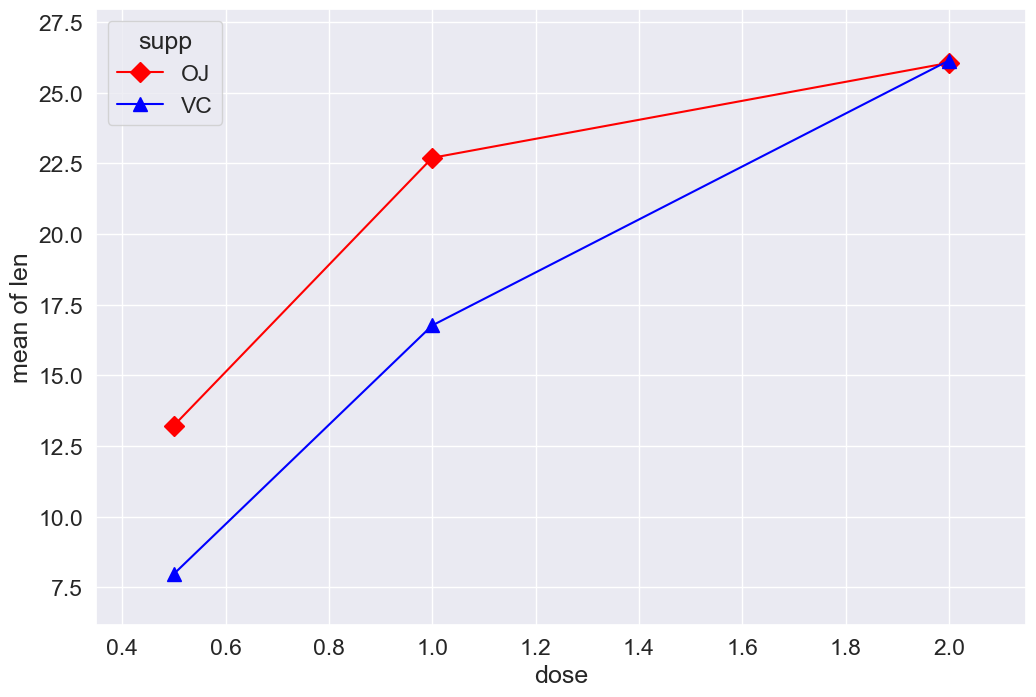

In [38]:
fig = interaction_plot(data.dose, 
                       data.supp, 
                       data.len,
                       colors=['red','blue'], markers=['D','^'], ms=10)
fig.set_figheight(8)
fig.set_figwidth(12)

## Two-way ANOVA

### Как считается F-статистика?

$$F = \frac{SSE_R - SSE_F}{df_R - df_F} \frac{df_F}{SSE_F},$$

где индекс $F$ обозначает полную модель, а индекс $R$ обозначает усечённую модель.

### Три способа ввести полную и усечённую модель

Если у нас есть два фактора, то мы можем выписать СЕМЬ моделей:

$$1.~~  y_{ijk} = \mu + \alpha_j + \beta_k + (\alpha \beta)_{jk} + \epsilon_{ijk}$$

$$2.~~  y_{ijk} = \mu + \alpha_j + \beta_k + \epsilon_{ijk}$$

$$3.~~  y_{ijk} = \mu + \alpha_j + (\alpha \beta)_{jk} + \epsilon_{ijk}$$

$$4.~~  y_{ijk} = \mu  + \beta_k + (\alpha \beta)_{jk} + \epsilon_{ijk}$$

$$5.~~  y_{ijk} = \mu + \alpha_j + \epsilon_{ijk}$$

$$6.~~  y_{ijk} = \mu + \beta_k + \epsilon_{ijk}$$

$$7.~~  y_{ijk} = \mu + \epsilon_{ijk}$$



В литературе встречаются три способа выбрать R и F, которые обозначаются как I, II и III (неофициальная, но широко используемая терминология).

##### Type I.

Ещё называется "sequentional" моделью. Показывает сколько дополнительной дисперсии объяснено при добавлении новых переменных. 

  * Главный эффект от фактора A: F=5, R=7
  
    SS(A)
    
    
  * Главный эффект от фактора B: F=2, R=5
  
    SS(B | A)
    
    
  * Взаимодействие эффектов: F=1, R=2
  
    SS(AB | A, B)
    
    
###### Type II.

Сколько дисперсии объясняет новая переменная, когда все остальные уже включены.

  * Главный эффект от фактора A: F=2, R=6
    
    SS(A | B)
    
    
  * Главный эффект от фактора B: F=2, R=5
  
    SS(B | A)
    
    
  * Взаимодействие эффектов: F=1, R=2
  
    SS(AB | A, B)
  
###### Type III. 

Сколько дисперсии объясняет новая переменная, когда все остальные уже включены, включая interaction term.


  * Главный эффект от фактора A: F=1, R=4
    
    SS(A | A, AB)
    
    
  * Главный эффект от фактора B: F=1, R=3
    
    SS(B | A, AB)
    
    
  * Взаимодействие эффектов: F=1, R=2
  
    SS(AB | A, B)
    
    
http://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html

Посчитаем все константы и степени свободы.

In [39]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1 # степени свободы по первому фактору
df_b = len(data.dose.unique()) - 1 # степени свободы по второму фактору
df_axb = df_a * df_b 
df_w = N - (len(data.supp.unique()) * len(data.dose.unique()))

Среднее по всем наблюдениям.

In [40]:
grand_mean = data['len'].mean()

Сумма ошибок между групповыми средними и общим средним.

In [41]:
ssq_a = sum([(data[data.supp==l].len.mean() - grand_mean)**2 for l in data.supp])

In [42]:
ssq_b = sum([(data[data.dose==l].len.mean() - grand_mean)**2 for l in data.dose])

Сумма ошибок между общим средним и измерениями. 

In [43]:
ssq_t = sum((data.len - grand_mean)**2)

Сумма ошибок между групповыми средними и измерениями.

In [44]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]
ssq_w = sum((oj.len - oj_dose_means)**2) + sum((vc.len - vc_dose_means)**2)

![](https://www.marsja.se/wp-content/uploads/2016/03/two-way-anova-sum-of-squares.png)

In [45]:
ssq_axb = ssq_t - ssq_a - ssq_b - ssq_w

In [46]:
ms_a = ssq_a / df_a

In [47]:
ms_b = ssq_b / df_b

In [48]:
ms_axb = ssq_axb / df_axb

In [49]:
ms_w = ssq_w / df_w

### F-статистики

In [50]:
f_a = ms_a / ms_w
f_b = ms_b / ms_w
f_axb = ms_axb / ms_w

### Посчитаем p-values

In [51]:
from scipy import stats

In [52]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

In [53]:
results = {
    'sum_sq': [ssq_a, ssq_b, ssq_axb, ssq_w],
    'df': [df_a, df_b, df_axb, df_w],
    'F': [f_a, f_b, f_axb, 'NaN'],
    'PR(>F)':[p_a, p_b, p_axb, 'NaN']
}

columns = ['sum_sq', 'df', 'F', 'PR(>F)']
 
aov_table1 = pd.DataFrame(results, 
                          columns=columns,
                          index=['supp', 'dose', 
                                 'supp:dose', 'Residual'])

In [54]:
data

,index,Unnamed: 0,len,supp,dose
0,0,1,4.2,VC,0.5
1,1,2,11.5,VC,0.5
2,2,3,7.3,VC,0.5
3,3,4,5.8,VC,0.5
4,4,5,6.4,VC,0.5
5,5,6,10.0,VC,0.5
6,6,7,11.2,VC,0.5
7,7,8,11.2,VC,0.5
8,8,9,5.2,VC,0.5
9,9,10,7.0,VC,0.5


In [55]:
formula = 'len ~ C(supp) * C(dose)'
lm = ols(formula, data).fit()
print(lm.summary())

anova_table = anova_lm(lm, typ=2)
anova_table

                            OLS Regression Results                            
Dep. Variable:                    len   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     41.56
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           2.50e-17
Time:                        13:02:39   Log-Likelihood:                -159.35
No. Observations:                  60   AIC:                             330.7
Df Residuals:                      54   BIC:                             343.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

,sum_sq,df,F,PR(>F)
C(supp),205.350000,1.0,15.571979,2.311828e-04
C(dose),2426.434333,2.0,91.999965,4.046291e-18
C(supp):C(dose),108.319000,2.0,4.106991,2.186027e-02
Residual,712.106000,54.0,NaN,NaN


In [56]:
0.02

0.02

In [57]:
aov_table1

,sum_sq,df,F,PR(>F)
supp,205.350000,1,15.571979,0.000231
dose,2426.434333,2,91.999965,0.0
supp:dose,108.319000,2,4.106991,0.02186
Residual,712.106000,54,NaN,NaN


### Немного дополнительных показателей связанных с величиной эффекта

  1. $\eta^2$, что-то вроде $R^2$ в регрессии.

$$\eta^2 = SSbetween / SStotal = SSB / SST$$

Классические эмпирические интерпретации $\eta^2$:

  * .02 ~ малая выраженность эффекта;
  * .13 ~ средняя выраженность эффект;
  * .26 ~ сильная выраженность эффекта.
  
  
  2. $\omega^2$ 
  
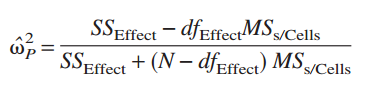

In [58]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq'] / sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1] / aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq'] - (aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table1)
omega_squared(aov_table1)
aov_table1

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
supp,205.350000,1,15.571979,0.000231,0.059484,0.055452
dose,2426.434333,2,91.999965,0.0,0.702864,0.692579
supp:dose,108.319000,2,4.106991,0.02186,0.031377,0.023647
Residual,712.106000,54,NaN,NaN,NaN,NaN


### ANOVA from `statsmodels`

In [59]:
formula = 'len ~ C(supp) * C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

eta_squared(aov_table)
omega_squared(aov_table)
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(supp),205.350000,1.0,15.571979,2.311828e-04,0.059484,0.055452
C(dose),2426.434333,2.0,91.999965,4.046291e-18,0.702864,0.692579
C(supp):C(dose),108.319000,2.0,4.106991,2.186027e-02,0.031377,0.023647
Residual,712.106000,54.0,NaN,NaN,NaN,NaN


### Q-Q график

Очень важно проверять, что остатки распределены нормально.

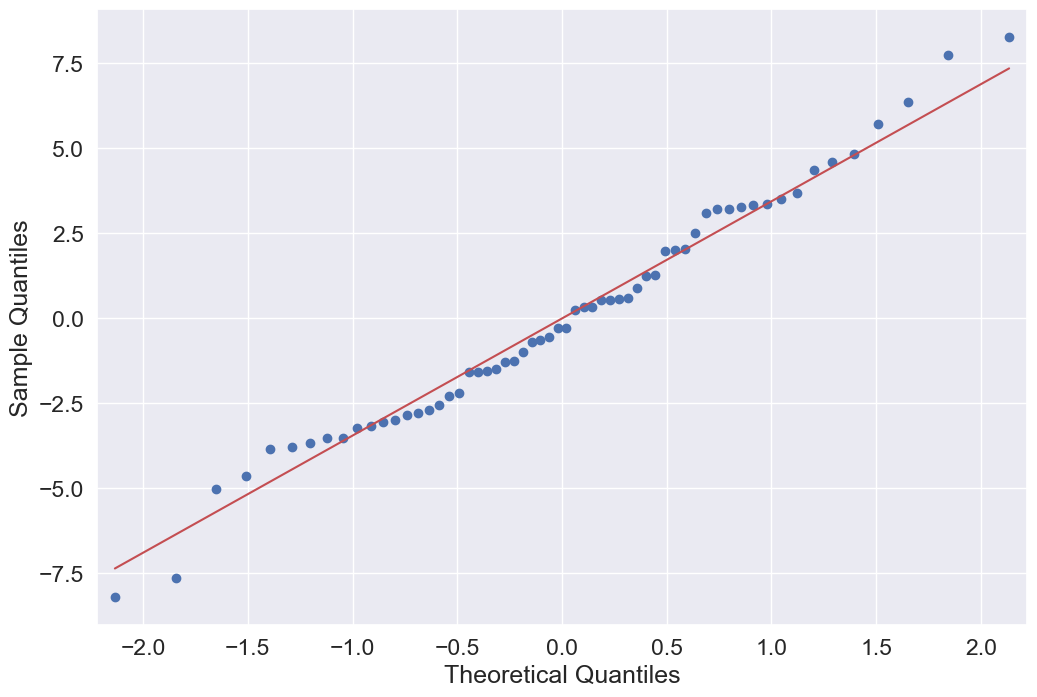

In [60]:
res = model.resid 
fig = sm.qqplot(res, line='s')
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

##### Критерий Шапиро-Уилка для проверки нормальности

In [61]:
stats.shapiro(res)

ShapiroResult(statistic=0.9849885702133179, pvalue=0.6694311499595642)

# ANCOVA

В ANCOVA (Analysis of covariance) добавляется ещё регрессия от некоторой величины, которая может оказывать влияние на интересующие нас переменные.

Если мы правильно выбрали регрессор, то вариация остатков должна уменьшиться.

Но при этом возможно увеличение дисперсии.

In [62]:
lm = ols("MPG ~ C(Origin) * Weight", auto_mpg).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          1.47e-121
Time:                        13:02:41   Log-Likelihood:                 157.02
No. Observations:                 392   AIC:                            -302.0
Df Residuals:                     386   BIC:                            -278.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.0905      0.046    -89.788      0.000      -4.180      -4.001
C(Origin)[T.2]            0.1448      0.111      1.310      0.191      -0.073       0.362
C(Origin)[T.3]           -0.1298      0.137     -0.945      0.345      -0.400       0.140
Weight                    0.0003   1.31e-05     25.739      0.000       0.000       0.000
C(Origin)[T.2]:Weight -6.941e-05   4.27e-05     -1.627      0.105      -0.000    1.45e-05
C(Origin)[T.3]:Weight  3.294e-05   5.92e-05      0.556      0.578   -8.34e-05       0.000
==============================================================================
Omnibus:                        4.668   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                5.361
Skew:                          -0.122   Prob(JB):                       0.0685
Kurtosis:                       3.518   Cond. No.                     5.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
anova_table = anova_lm(lm, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,215.146957,1.0,8061.925222,9.269477e-261
C(Origin),0.080165,2.0,1.501952,2.239936e-01
Weight,17.680040,1.0,662.501398,8.890714e-86
C(Origin):Weight,0.082622,2.0,1.547988,2.139927e-01
Residual,10.301103,386.0,NaN,NaN


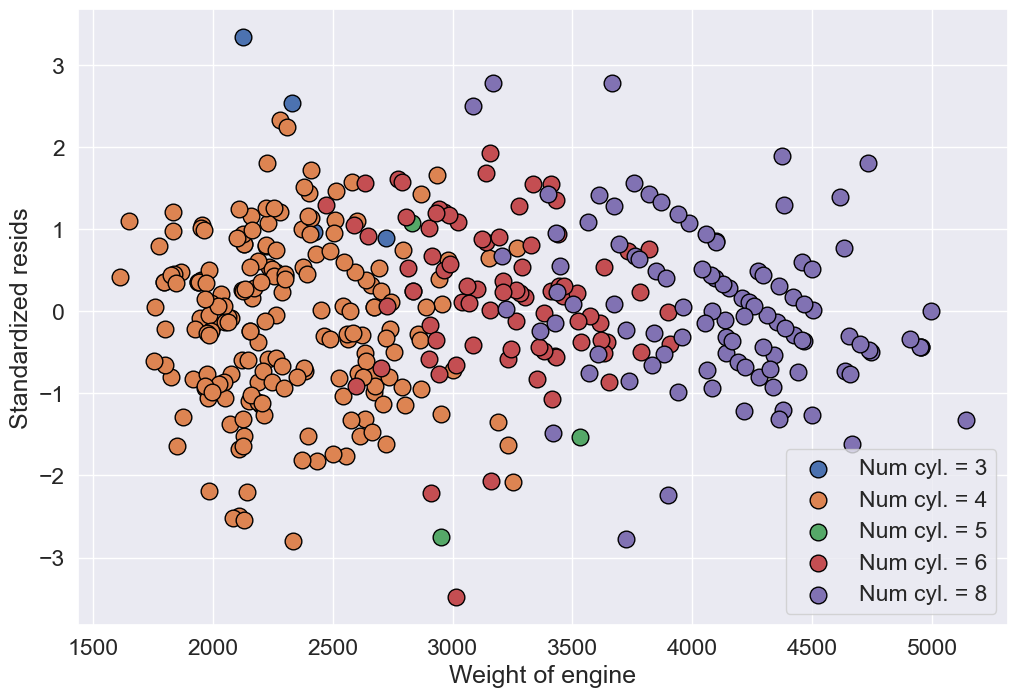

In [64]:
infl = lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(12, 8))
for cylinder, group in auto_mpg.groupby(['Cylinders']):
    plt.scatter(auto_mpg.Weight[group.index], resid[group.index], s=144, 
                edgecolors='black', label='Num cyl. = {}'.format(cylinder))
plt.xlabel('Weight of engine');
plt.ylabel('Standardized resids');
plt.legend();

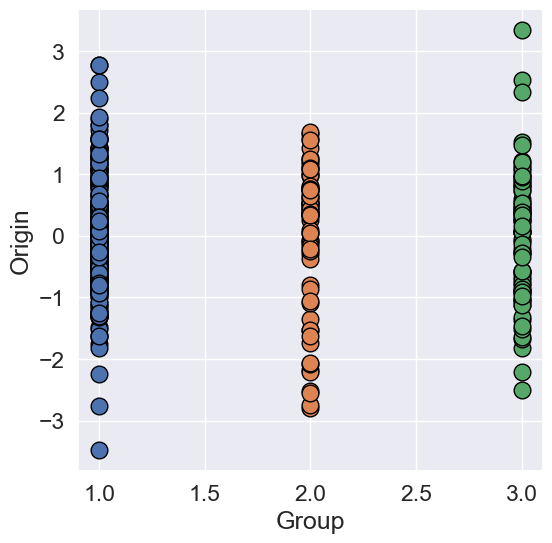

In [65]:
plt.figure(figsize=(6,6));
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
for value, group in auto_mpg.groupby(['Origin']):
    x = [value] * len(group)
    plt.scatter(x, resid[group.index],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Origin');

In [66]:
import IPython
for typ in ['I', 'II', 'III']:
    anova_table = anova_lm(lm, typ=typ)
    IPython.display.display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,14.950773,7.475386,280.115536,6.980543e-76
Weight,1.0,19.875463,19.875463,744.767679,4.062089e-92
C(Origin):Weight,2.0,0.082622,0.041311,1.547988,2.139927e-01
Residual,386.0,10.301103,0.026687,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Origin),0.160266,2.0,3.002717,5.081324e-02
Weight,19.875463,1.0,744.767679,4.062089e-92
C(Origin):Weight,0.082622,2.0,1.547988,2.139927e-01
Residual,10.301103,386.0,NaN,NaN


,sum_sq,df,F,PR(>F)
Intercept,215.146957,1.0,8061.925222,9.269477e-261
C(Origin),0.080165,2.0,1.501952,2.239936e-01
Weight,17.680040,1.0,662.501398,8.890714e-86
C(Origin):Weight,0.082622,2.0,1.547988,2.139927e-01
Residual,10.301103,386.0,NaN,NaN


## Тестирование предположений ANCOVA

  * Зависимость между x и y линейная;
  * Зависимость между x и y одинаковая для разных групп (параллельность);
  * __Независимость x от группы__ (потому что условия в которых находятся испытуемые должны быть одинаковы);
  * $y | x ~ \mathcal{N}(\mu + \alpha_j + \beta(x_{ij} - \bar{x}), \sigma^2)$ -- гомогенность дисперсии.

#### 1. Линейная зависимость от "ковариации" того что мы хотим предсказывать

In [67]:
lm = ols("MPG ~ Weight", auto_mpg).fit()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
Weight,1.0,34.665970,34.665970,1282.221169,2.392115e-125
Residual,390.0,10.543991,0.027036,NaN,NaN


p-value равно нулю, как и std err, поэтому первое предположение верно.

#### 2. Параллельность наклонов

In [68]:
lm = ols("MPG ~ Weight * C(Origin)", auto_mpg).fit()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,14.950773,7.475386,280.115536,6.980543e-76
Weight,1.0,19.875463,19.875463,744.767679,4.062089e-92
Weight:C(Origin),2.0,0.082622,0.041311,1.547988,2.139927e-01
Residual,386.0,10.301103,0.026687,NaN,NaN


`p-value` =  0.00435, что, вообще говоря, не очень хорошо.

Мы бы ожидали увидеть здесь большое `p-value`, что означало бы, что предположение о параллельности наклонов выполняется.

#### 3. Тестирование на наличие зависимости "ковариации" от категориальной фичи 

In [69]:
lm = ols("Weight ~ C(Origin)", auto_mpg).fit()
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Origin),2.0,1.035338e+08,5.176691e+07,112.772038,2.353054e-39
Residual,389.0,1.785667e+08,4.590403e+05,NaN,NaN


Очень сильная зависимость между весом и страной-производителем, что тоже не соответствует предположениям ANOVA.

#### 4. Тестирование  гипотезы о гомогенности дисперсии

https://en.wikipedia.org/wiki/Levene%27s_test

In [70]:
from scipy.stats import levene

In [71]:
levene?

In [72]:
levene(auto_mpg[auto_mpg.Origin==1].MPG,
       auto_mpg[auto_mpg.Origin==2].MPG,
       auto_mpg[auto_mpg.Origin==3].MPG)

LeveneResult(statistic=11.084787110808314, pvalue=2.080265441259721e-05)

Тест о гомогенности дисперсии пройден :)

##### Очень важно тестировать эти предположения перед проведением теста, так как верность предпосылок напрямую влияет на достоверность выводов

# 